In [1]:
import pandas as pd

In [5]:
train_dataset = pd.read_csv('train.csv', index_col='Unnamed: 0')
validate_dataset = pd.read_csv('val.csv', index_col='Unnamed: 0')

In [107]:
from torchvision import datasets

In [117]:
import numpy as np
class Model:
    def __init__(self, labels, input_size, output_len = 4, weight_bound = 0.03):
        self.w = np.random.uniform(-weight_bound, weight_bound, [input_size+1, output_len])
        self.act = np.random.uniform(0, 0.5)
        self.label2id = {l:i for i, l in enumerate(labels)}
        self.id2label = labels

    def forward(self, x:np.ndarray):
        # x = x.flatten()
        x = np.append(x, 1)
        out = np.dot(x,self.w)
        activated = (out>self.act)*1
        return activated

    def step(self, x:np.ndarray, y:str, lr, validate=False):
        y = self.label2id[y]
        target = np.zeros(self.w.shape[1])
        target[y]=1
        pred = self.forward(x)
        x = np.append(x, 1)
        eps = target - pred
        x = np.repeat(x, self.w.shape[1]).reshape(self.w.shape)
        dw = eps*x*lr
        if not validate:
            self.w += dw
        return np.abs(dw).sum(), (target.shape[0] - np.abs(eps).sum()) / target.shape[0]

  0%|          | 0/100 [00:00<?, ?it/s]

0.08237334999999998 0.42578125
0.08148994999999999 0.4296875
0.0783903 0.44921875
0.0774933 0.453125
0.07728614999999998 0.453125
0.07666284999999998 0.45703125
0.07595869999999998 0.4609375
0.0741652 0.47265625
0.0734732 0.4765625
0.07227009999999998 0.484375
0.06949759999999999 0.50390625
0.06905399999999999 0.5078125
0.06655729999999999 0.5234375
0.06565444999999999 0.53125
0.06181084999999998 0.55859375
0.06011674999999998 0.5703125
0.05855 0.58203125
0.059056899999999996 0.578125
0.0576553 0.58984375
0.056556099999999984 0.6015625
0.05523235 0.61328125
0.0513778 0.640625
0.04904064999999998 0.66015625
0.047934550000000006 0.66796875
0.046478900000000004 0.6796875
0.04601145 0.68359375
0.043901199999999994 0.69921875
0.044013849999999986 0.69921875
0.042752700000000005 0.70703125
0.04338074999999998 0.703125
0.04141559999999999 0.71875
0.040902649999999985 0.72265625
0.04200874999999999 0.71484375
0.039708949999999986 0.73046875
0.0381482 0.7421875
0.03713074999999998 0.75
0.035029

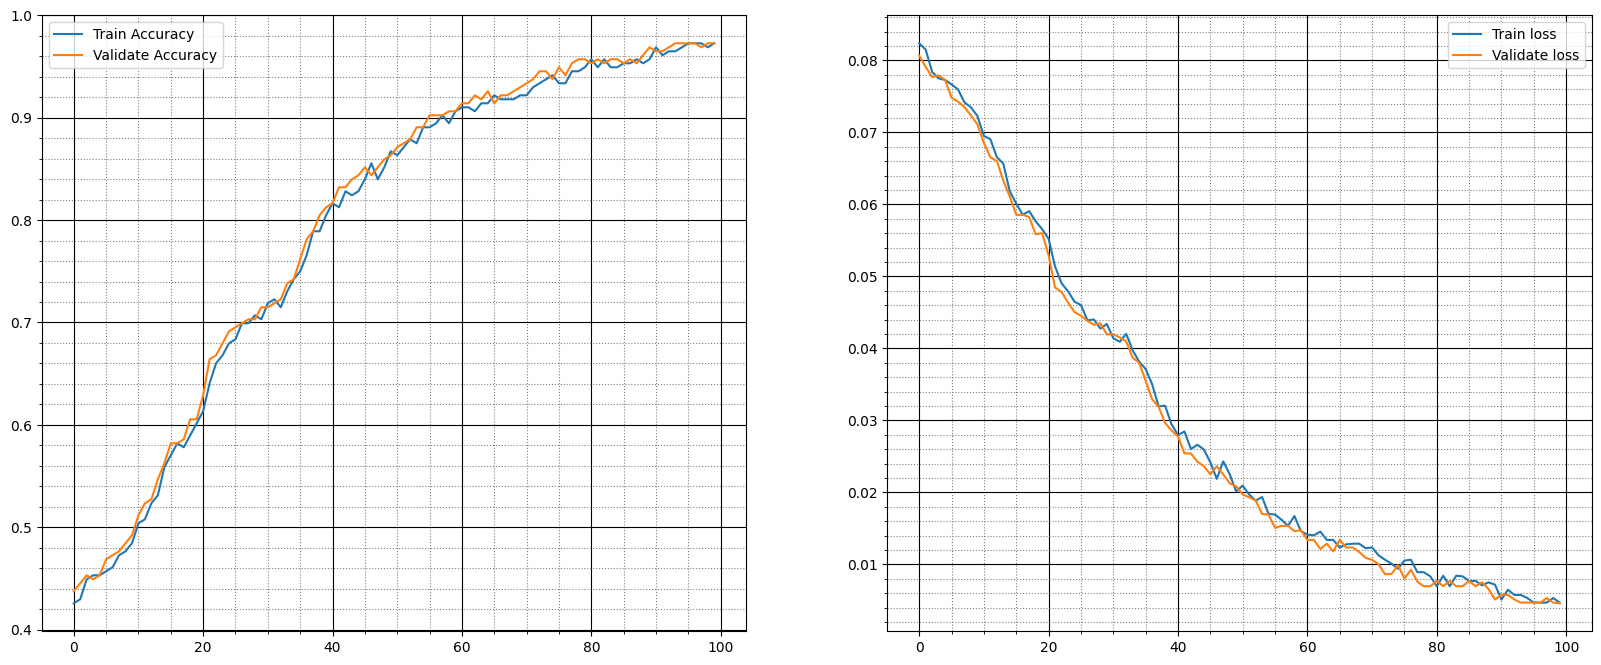

In [159]:
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
np.random.seed(42)

pbar = tqdm(range(100))
metric = defaultdict(list)
lr = np.random.uniform(0.000005, 0.000006)
lr = 5e-8
model = Model(['a', 'b', 'v', 'x'], 10*10)

def train_or_val(df, validate=False):
    loss = 0
    acc = 0
    for i,row in df.iterrows():
        img = Image.open(row['path'])
        img = img.resize((10,10))
        x = np.asarray(img)
        loss_step, acc_step = model.step(x, row['label'], lr, validate)
        loss+=loss_step
        acc+=acc_step
        
    acc /= len(df)
    s = "validate" if validate else "train"
    metric[f'{s}_acc'].append(acc)
    metric[f'{s}_loss'].append(loss)
    return acc, loss


for epoch in pbar:
    train_shuffled = train_dataset.sample(frac=1)
    acc, loss = train_or_val(train_shuffled)
    print(loss, acc)
    if loss<1e-10:
        print('No changes in weights. Stopped')
        break
    
    train_or_val(train_shuffled, True)
    
    pbar.set_postfix({key:val[-1] for key,val in metric.items()})


fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].plot(metric['train_acc'], label='Train Accuracy')
axs[0].plot(metric['validate_acc'], label='Validate Accuracy')

axs[1].plot(metric['train_loss'], label='Train loss')
axs[1].plot(metric['validate_loss'], label='Validate loss')

axs[0].legend()
axs[1].legend()

axs[0].minorticks_on()
axs[0].grid(which='major',
        color = 'k')
axs[0].grid(which='minor',
        color = 'gray',
        linestyle = ':')

axs[1].minorticks_on()
axs[1].grid(which='major',
        color = 'k')
axs[1].grid(which='minor',
        color = 'gray',
        linestyle = ':')